In [22]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
from enum import Enum
import random
import copy 
import time

## Clases utiles para visualizar los resultados

In [23]:
@dataclass
class Node:
    student_info: list
    calendar: list

class Student(Enum):
    GUSTAVO = 0
    GABRIELA = 1
    JUAN = 2
    LUIS = 3

class Subject(Enum):
    MATH = 0
    HISTORY = 1
    PHYSICS = 2
    CHEMISTRY = 3
    SPANISH = 4
    ENGLISH = 5
    BIOLOGY = 6

class Day(Enum):
    MONDAY = 0
    TUESDAY = 1
    WEDNESDAY = 2

MAX_CLASSES_PER_STUDENT = 3
MAX_CLASSES_PER_DAY = len(Student)

## Inicialización del Estado Inicial

In [24]:
global_subjects = list(Subject)

def pick_subjects():
    """Esta funcion se encarga de asignar materias a los estudiantes de la forma mas diversa posible.
    Esto es importante porque de lo contrario se podria dar el caso de que todos los estudiantes se 
    asignen las mismas materias y no se pueda resolver el problema.
    """
    global global_subjects
    
    if len(global_subjects) == 0:
        global_subjects = list(Subject)
    
    if len(global_subjects) < MAX_CLASSES_PER_STUDENT:
        classes = [global_subjects.pop() for _ in range(len(global_subjects))]
        len_classes = len(classes)
        global_subjects = list(Subject)
        random.shuffle(global_subjects)

        for _ in range(MAX_CLASSES_PER_STUDENT - len_classes):
            classes.append(global_subjects.pop())
    else:
        random.shuffle(global_subjects)
        classes = [global_subjects.pop() for _ in range(MAX_CLASSES_PER_STUDENT)]

    return classes

def do_calendar(student_info):
    """
    Esta funcion se encarga de crear un calendario con las materias asignadas a los estudiantes.
    """
    calendar = {day: [] for day in Day}

    for student in Student:
        for subject, day in student_info[student]:
            calendar[day].append(subject)

    return calendar

              
def initial_node_initializer():
    """
    Esta funcion se encarga de inicializar las variables de forma que se asegure
    que el problema se pueda resolver. Es decir que todos los estudiantes no se 
    asignen mas materias de las que hay dias; y que no los alumnos no se asignen todos
    exactamente las mismas materias.
    """
    student_info = {}
    

    for student in Student:
        classes = pick_subjects()
        days = random.sample(list(Day), MAX_CLASSES_PER_STUDENT)
        student_info[student] = list(zip(classes, days))

    calendar = do_calendar(student_info)
        
    return Node(student_info, calendar)


## Funciones Utiles para Beam Search

In [25]:
def scoring_function(node: Node):
    """
    Esta funcion se encarga de evaluar la calidad de la solucion propuesta, en este caso la calendarizacion.
    """
    calendar = node.calendar
    student_info = node.student_info
    repeated_subjects_count = 0

    for day in calendar.keys():        
        days_set = set(calendar[day])        
        if len(days_set) < MAX_CLASSES_PER_DAY:
            repeated_subjects_count +=  MAX_CLASSES_PER_DAY - len(days_set) 

    for student in student_info.keys():
        days_set = set(day for _, day in student_info[student])
        if len(days_set) < MAX_CLASSES_PER_STUDENT:
            repeated_subjects_count += MAX_CLASSES_PER_STUDENT - len(days_set)

    return repeated_subjects_count



def huristic(node: Node):
    """
    implementar la heuristica para resolver el problema. Permutar los dias de los examenes de los estudiantes
    """
    student_info = copy.deepcopy(node.student_info)

    students_selected = random.sample(list(Student), 2)
    student1, student2 = students_selected

    random.shuffle(student_info[student1])
    stud1_class = list(student_info[student1].pop())

    random.shuffle(student_info[student2])
    stud2_class = list(student_info[student2].pop())

    stud1_class_day = stud1_class[1]
    stud2_class_day = stud2_class[1]

    stud1_class[1] = stud2_class_day
    stud2_class[1] = stud1_class_day

    student_info[student1].append(tuple(stud1_class))
    student_info[student2].append(tuple(stud2_class))

    return Node(student_info, do_calendar(student_info))


## Beam Search Class

In [26]:
class BeamSearch:
    def __init__(self, score_function: callable, heuristic: callable, initial_object,\
                  best_score=0, beam_width=2, max_iterations=100):
        """
        Args:
            score_function (callable): Esta funcion toma como parametro el objeto tipo initial object y retorna un valor numerico
            heuristic (callable): La modificacion que se va a hacer al objeto para generar nuevos objetos
            initial_object (_type_): El objeto del estado inicial
            beam_width (int, optional): Beam width. Defaults to 2.
            max_iterations (int, optional): Cantidad máxima de iteraciones. Defaults to 100.
        """

        # Functions
        self.score_function = score_function
        self.heuristic = heuristic

        # Object
        self.initial_object = initial_object

        # Hyperparameters
        self.beam_width = beam_width
        self.max_iterations = max_iterations
        self.best_score = best_score

        self.best_node = None        
        self.best_object = None

        # C list
        self.C = [(initial_object, self.score_function(initial_object))]


    def _iteration(self):        
        current = []
        for object_tuple in self.C:
            for _ in range(self.beam_width):
                new_object = self.heuristic(object_tuple[0])
                new_score = self.score_function(new_object)

                current.append(tuple((new_object, new_score)))
            
        self.C += current

        # Ordenamos la lista de acuerdo a la funcion de scoring
        self.C = sorted(self.C, key=lambda x: x[1])

        # Nos quedamos con los mejores elementos
        if len(self.C) > self.beam_width:
            self.C = self.C[:self.beam_width]


    def search(self):
        # revisamos que el caso inicial sea el mejor
        if self.score_function(self.initial_object) == self.best_score:
            return self.initial_object, self.best_score

        for _ in range(self.max_iterations):
            self._iteration()

        self.best_object = self.C[0]
        best_object_score = self.best_object[1]

        return self.best_object[0], best_object_score
    

## Ejemplo de resultado

In [27]:
def print_schedule(schedule):
    for student, subjects in schedule.items():
        print(f"{student.name}:")
        for subject, day in subjects:
            print(f"  {subject.name} on {day.name}")
        print()

init = initial_node_initializer()
beam_search = BeamSearch(scoring_function, huristic, init)
result = beam_search.search()[0].student_info
print_schedule(result)

GUSTAVO:
  PHYSICS on MONDAY
  HISTORY on TUESDAY
  SPANISH on WEDNESDAY

GABRIELA:
  CHEMISTRY on TUESDAY
  ENGLISH on WEDNESDAY
  BIOLOGY on MONDAY

JUAN:
  MATH on WEDNESDAY
  CHEMISTRY on MONDAY
  PHYSICS on TUESDAY

LUIS:
  MATH on TUESDAY
  BIOLOGY on MONDAY
  HISTORY on WEDNESDAY



## Performace

In [28]:
max_iter = 100
tests = 10
beam_width = 10
execution_times = []
execution_scores = []

for i in range(tests):
    init = initial_node_initializer()
    beam_search = BeamSearch(scoring_function, huristic, init, beam_width=beam_width, max_iterations=max_iter)

    start_time = time.time()
    best_object, best_score = beam_search.search()
    end_time = time.time()

    execution_time = end_time - start_time
    execution_times.append(execution_time)
    execution_scores.append(best_score)

print(execution_times)
print(execution_scores)

[1.5297105312347412, 1.334843635559082, 0.0, 1.085829734802246, 1.5910234451293945, 1.1328654289245605, 1.469191551208496, 1.1177763938903809, 1.1972742080688477, 1.1148195266723633]
[0, 0, 0, 1, 0, 2, 0, 0, 0, 1]


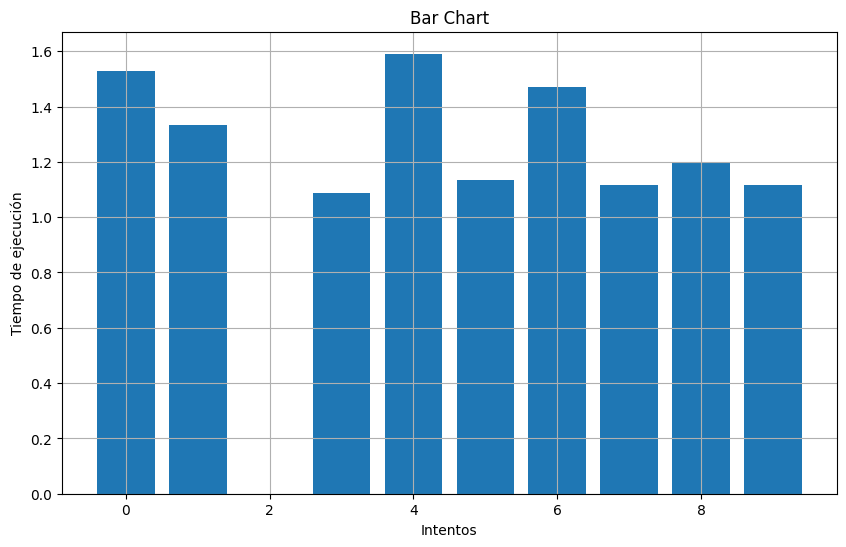

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(execution_times)), execution_times)
plt.title('Bar Chart')
plt.xlabel('Intentos')
plt.ylabel('Tiempo de ejecución')
plt.grid(True)
plt.show()

Todos los casos fuerone exitosos lo unico que varió fue el tiempo de ejecución.